# 3.2 Adapting to Real Predictions: Complete Model

In [1]:
import json
import numpy as np
import pandas as pd
import tensorflow as tf
import tensorflow_recommenders as tfrs

We begin by importing the data and metadata we saved on project #1 and exporting vocabularies:

In [2]:
train_df = pd.read_csv('../local_data/train_data.csv', header=0)
test_df = pd.read_csv('../local_data/test_data.csv', header=0)
with open('../local_data/metadata.json', 'r') as f:
    metadata = json.load(f)

In [3]:
all_users = [str(int(i)) for i in metadata['users']]
all_movies = [str(int(i)) for i in metadata['movies']]
all_cities = metadata['cities']
all_states = metadata['states']
all_ages = [str(int(i)) for i in metadata['ages']]
all_occupations = [str(int(i)) for i in metadata['occupations']]
all_genres = metadata['genres']
title_emb_len = metadata['title_emb_size']
na_value = metadata['string_na']

Converting to datasets:

In [4]:
def convert_to_dataset(df):
    movie_features = ['movie', 'title_emb', 'genres', 'movie_year', 'rating']
    d = {k:v.to_numpy() for k,v in dict(df).items()}
    d['genres'] = np.transpose(np.array([d[x] for x in all_genres]))
    d['title_emb'] = np.transpose(np.array([d[f'title_emb_{i}'] for i in range(title_emb_len)]))
    for x in all_genres + [f'title_emb_{i}' for i in range(title_emb_len)]:
        d.pop(x)
    d = {k:(np.expand_dims(v, axis=1) if k in movie_features else v) for k,v in d.items()}
    return tf.data.Dataset.from_tensor_slices(d)

train_dataset = convert_to_dataset(train_df)
test_dataset = convert_to_dataset(test_df)

2021-11-13 14:28:05.452697: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


Below is the model design of milestone #2.3, but this time, the shapes of all movie features has an additional dimension. 

In [5]:
class RatingPredictionModel(tfrs.models.Model):
    def __init__(self):
        super().__init__()
        
        tower_last_layer_size = 50
        large_embedding_size = 25
        medium_embedding_size = 5
        small_embedding_size = 3
        
        # User tower
        
        self.user_input = tf.keras.Input(shape=(1,), dtype=tf.string, name='user_input')
        self.user_sl = tf.keras.layers.StringLookup(vocabulary=all_users, name='user_string_lookup')(self.user_input)
        self.user_emb = tf.squeeze(tf.keras.layers.Embedding(len(all_users)+1, large_embedding_size, name='user_emb')(self.user_sl), axis=1)
        
        self.city_input = tf.keras.Input(shape=(1,), dtype=tf.string, name='city_input')
        self.city_sl = tf.keras.layers.StringLookup(vocabulary=all_cities, mask_token=na_value, name='city_string_lookup')(self.city_input)
        self.city_emb = tf.squeeze(tf.keras.layers.Embedding(len(all_cities)+2, medium_embedding_size, name='city_emb')(self.city_sl), axis=1)
        
        self.state_input = tf.keras.Input(shape=(1,), dtype=tf.string, name='state_input')
        self.state_sl = tf.keras.layers.StringLookup(vocabulary=all_states, mask_token=na_value, name='state_string_lookup')(self.state_input)
        self.state_emb = tf.squeeze(tf.keras.layers.Embedding(len(all_states)+2, small_embedding_size, name='state_emb')(self.state_sl), axis=1)
        
        self.age_input = tf.keras.Input(shape=(1,), dtype=tf.string, name='age_input')
        self.age_sl = tf.keras.layers.StringLookup(vocabulary=all_ages, num_oov_indices=0, name='age_string_lookup')(self.age_input)
        self.age_emb = tf.squeeze(tf.keras.layers.Embedding(len(all_ages), small_embedding_size, name='age_emb')(self.age_sl), axis=1)
        
        self.occupation_input = tf.keras.Input(shape=(1,), dtype=tf.string, name='occupation_input')
        self.occupation_sl = tf.keras.layers.StringLookup(vocabulary=all_occupations, num_oov_indices=0, name='occupation_string_lookup')(self.occupation_input)
        self.occupation_emb = tf.squeeze(tf.keras.layers.Embedding(len(all_occupations), small_embedding_size, name='occupation_emb')(self.occupation_sl), axis=1)
        
        self.gender_input = tf.keras.Input(shape=(1,), name='gender_input')
        self.hour_input = tf.keras.Input(shape=(1,), name='hour_input')
        self.day_input = tf.keras.Input(shape=(1,), name='day_input')
        self.month_input = tf.keras.Input(shape=(1,), name='month_input')
        
        self.user_merged = tf.keras.layers.concatenate([self.user_emb, self.city_emb, self.state_emb, self.age_emb, 
                                                        self.occupation_emb, self.gender_input, self.hour_input,
                                                        self.day_input, self.month_input], 
                                                       axis=-1, name='user_merged')
        self.user_dense = tf.keras.layers.Dense(100, activation='relu', name='user_dense')(self.user_merged)
        self.user_last_layer = tf.keras.layers.Dense(tower_last_layer_size, activation='relu', name='user_last_layer')(self.user_dense)
        
        # Movie tower
        
        self.movie_input = tf.keras.Input(shape=(None,1), dtype=tf.string, name='movie_input ')
        self.movie_sl = tf.keras.layers.StringLookup(vocabulary=all_movies, name='movie_string_lookup')(self.movie_input)
        self.movie_emb = tf.squeeze(tf.keras.layers.Embedding(len(all_movies)+1, large_embedding_size, name='movie_emb')(self.movie_sl), axis=2)
        
        self.title_input = tf.keras.Input(shape=(None,title_emb_len), name='title_input')
        self.title_dense = tf.keras.layers.Dense(title_emb_len, activation='softmax', name='title_softmax')(self.title_input)
        
        self.genres_input = tf.keras.Input(shape=(None,len(all_genres)), name='genres_input')
        self.year_input = tf.keras.Input(shape=(None,1), name='year_input')
        
        self.movie_merged = tf.keras.layers.concatenate([self.movie_emb, self.title_dense, self.genres_input, self.year_input] ,axis=-1, name='movie_merged')
        self.movie_dense = tf.keras.layers.Dense(100, activation='relu', name='movie_dense')(self.movie_merged)
        self.movie_last_layer = tf.keras.layers.Dense(tower_last_layer_size, activation='relu', name='movie_last_layer')(self.movie_dense)
        
        # Combining towers
        
        self.towers_multiplied = tf.keras.layers.Multiply(name='towers_multiplied')([tf.expand_dims(self.user_last_layer, axis=2), 
                                                                                     tf.transpose(self.movie_last_layer, perm=[0,2,1])])
        self.towers_dense1 = tf.keras.layers.Dense(40, activation='relu', name='towers_dense1')(tf.transpose(self.towers_multiplied, perm=[0,2,1]))
        self.towers_dense2 = tf.keras.layers.Dense(20, activation='relu', name='towers_dense2')(self.towers_dense1)
        self.output_node = tf.keras.layers.Dense(1, name='output_node')(self.towers_dense2)
        
        # Model definition
        
        self.model = tf.keras.Model(inputs={'user': self.user_input, 
                                            'city': self.city_input,
                                            'state': self.state_input,
                                            'age': self.age_input,
                                            'occupation': self.occupation_input,
                                            'gender': self.gender_input,
                                            'hour': self.hour_input,
                                            'day': self.day_input,
                                            'month': self.month_input,
                                            'movie': self.movie_input,
                                            'title': self.title_input,
                                            'genres': self.genres_input,
                                            'year': self.year_input
                                            }, 
                                    outputs=self.output_node)
        
        self.task = tfrs.tasks.Ranking(
            loss = tf.keras.losses.MeanSquaredError(),
            metrics=[tf.keras.metrics.RootMeanSquaredError()]
        )
        
    def call(self, features):
        return self.model({'user': tf.strings.as_string(features["user"]), 
                           'city': features["city"], 
                           'state': features["state"],
                           'age': tf.strings.as_string(features["age"]),
                           'occupation': tf.strings.as_string(features["occupation"]), 
                           'gender': features["gender"],
                           'hour': features["hour"],
                           'day': features["day"],
                           'month': features["month"],
                           'movie': tf.strings.as_string(features["movie"]),
                           'title': features["title_emb"],
                           'genres': features["genres"],
                           'year': features["movie_year"]
                           })
    
    def compute_loss(self, features_dict, training=False):
        labels = features_dict["rating"]
        predictions = self(features_dict)
        return self.task(labels=labels, predictions=predictions)

Training and evaluating:

In [6]:
model = RatingPredictionModel()
learning_rate = tf.keras.optimizers.schedules.ExponentialDecay(1e-2, decay_steps=4000, decay_rate=0.95)
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate))
cached_train = train_dataset.shuffle(15_000).batch(10_000).cache()
early_stopping = tf.keras.callbacks.EarlyStopping(monitor='loss', restore_best_weights=True, patience=5)
model.fit(cached_train, epochs=1000, callbacks=[early_stopping])

Epoch 1/1000


2021-11-13 14:28:07.840269: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


96/96 [==============================] - 17s 156ms/step - root_mean_squared_error: 24.2843 - loss: 577.7288 - regularization_loss: 0.0000e+00 - total_loss: 577.7288
Epoch 2/1000
96/96 [==============================] - 2s 25ms/step - root_mean_squared_error: 1.3221 - loss: 1.7518 - regularization_loss: 0.0000e+00 - total_loss: 1.7518
Epoch 3/1000
96/96 [==============================] - 2s 24ms/step - root_mean_squared_error: 1.2244 - loss: 1.4984 - regularization_loss: 0.0000e+00 - total_loss: 1.4984
Epoch 4/1000
96/96 [==============================] - 2s 25ms/step - root_mean_squared_error: 1.1876 - loss: 1.4073 - regularization_loss: 0.0000e+00 - total_loss: 1.4073
Epoch 5/1000
96/96 [==============================] - 2s 25ms/step - root_mean_squared_error: 1.1637 - loss: 1.3486 - regularization_loss: 0.0000e+00 - total_loss: 1.3486
Epoch 6/1000
96/96 [==============================] - 2s 26ms/step - root_mean_squared_error: 1.1528 - loss: 1.3234 - regularization_loss: 0.0000e+00 -

In [7]:
cached_test = test_dataset.batch(5000).cache()
model.evaluate(cached_test, return_dict=True)

11/11 [==============================] - 1s 46ms/step - root_mean_squared_error: 0.9631 - loss: 0.9569 - regularization_loss: 0.0000e+00 - total_loss: 0.9569


{'root_mean_squared_error': 0.963071882724762,
 'loss': 1.1039007902145386,
 'regularization_loss': 0,
 'total_loss': 1.1039007902145386}

We've reached $RMSE = 0.96$.

Now for a single prediction imitation - one user's rating predictions over 30 movies, all done at once:

In [8]:
num_of_movies = 30

x = {k:np.asarray([v]) for k,v in list(test_dataset.take(1).as_numpy_iterator())[0].items()}
x.pop('rating', None)
dfx = pd.DataFrame(list(test_dataset.take(num_of_movies).as_numpy_iterator()))[['movie', 'title_emb', 'genres', 'movie_year']]
x.update({k:np.expand_dims(np.vstack(v), axis=0) for k,v in dict(dfx).items()})

pred = model.predict(x)
print(f"Predictions for user {x['user'][0]}:\n-------")
for i in range(num_of_movies):
    print(f"Movie {x['movie'][0][i][0]}:\t{pred[0][i][0]:.2f}")

Predictions for user 6040:
-------
Movie 858:	4.17
Movie 2858:	4.01
Movie 448:	2.97
Movie 1834:	3.74
Movie 955:	3.92
Movie 1078:	3.63
Movie 915:	3.76
Movie 364:	3.66
Movie 199:	2.93
Movie 923:	4.08
Movie 1882:	2.17
Movie 908:	4.08
Movie 2826:	2.87
Movie 2710:	2.76
Movie 2919:	3.65
Movie 17:	3.78
Movie 2333:	3.61
Movie 2805:	2.67
Movie 3363:	3.77
Movie 2396:	3.86
Movie 3179:	2.95
Movie 3307:	4.00
Movie 1617:	3.94
Movie 903:	3.99
Movie 2628:	3.10
Movie 504:	2.88
Movie 2393:	3.06
Movie 514:	3.34
Movie 737:	1.95
Movie 446:	3.04


We'll now plot and save the model.

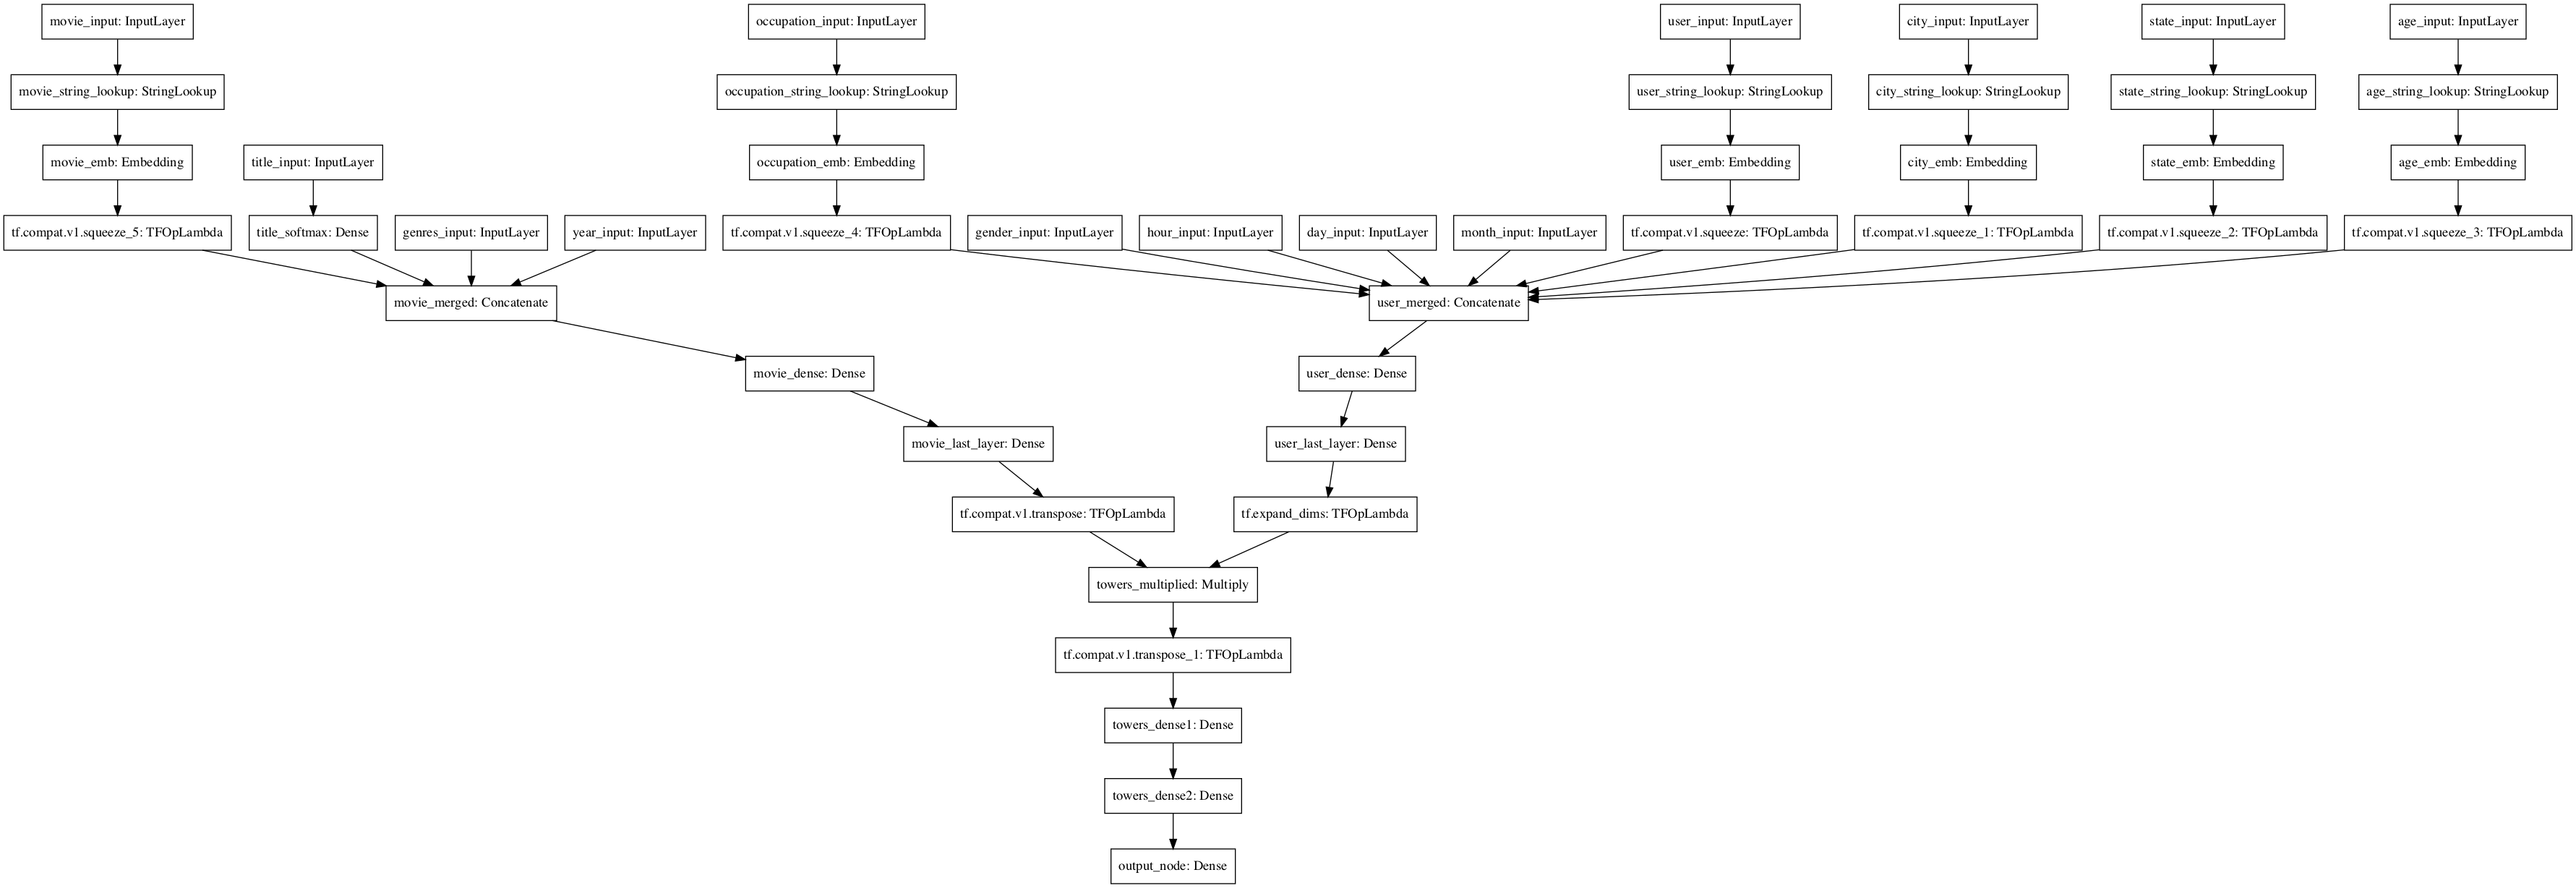

In [9]:
tf.keras.utils.plot_model(model.model, to_file="project_3_2.png")

In [10]:
model.model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
user_input (InputLayer)         [(None, 1)]          0                                            
__________________________________________________________________________________________________
city_input (InputLayer)         [(None, 1)]          0                                            
__________________________________________________________________________________________________
state_input (InputLayer)        [(None, 1)]          0                                            
__________________________________________________________________________________________________
age_input (InputLayer)          [(None, 1)]          0                                            
______________________________________________________________________________________________

In [11]:
model.save_weights('weights_3_2/p32')